In [1]:
"""
ADOBE CONFIDENTIAL
Copyright 2024 Adobe
All Rights Reserved.
NOTICE: All information contained herein is, and remains
the property of Adobe and its suppliers, if any. The intellectual
and technical concepts contained herein are proprietary to Adobe 
and its suppliers and are protected by all applicable intellectual 
property laws, including trade secret and copyright laws. 
Dissemination of this information or reproduction of this material is 
strictly forbidden unless prior written permission is obtained from Adobe.
"""

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
from lora_diffusion import patch_pipe
import torch
import torch.nn as nn
import os
from transformers import CLIPTextModel, CLIPTokenizer
from training_scripts.continuous_word_mlp import continuous_word_mlp

model_id = "stabilityai/stable-diffusion-2-1"

cur_model = "illumination_orientation" 
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda"
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
patch_pipe(
    pipe,
    "ckpts/" + cur_model + "_sd.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

continuous_word_model = continuous_word_mlp(input_size = 4, output_size = 2048)
continuous_word_model.load_state_dict(torch.load("ckpts/" + cur_model + "_mlp.pt"))
continuous_word_model.eval()

tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")




In [23]:
"""Set the attributes of orientation and illumination"""
orientations = [0 for i in range(16)]
illuminations = [i+2 for i in range(16)]

In [32]:
cur_token = 'sks'
cur_token2 = 'hta'
img_list = []

"""Obtain the corresponding embeddings of the rare tokens to be replaced by MLP output"""
corresponding_emb = tokenizer(cur_token,
        padding="do_not_pad", \
         truncation=True, \
         max_length = tokenizer.model_max_length).input_ids[1]

corresponding_emb2 = tokenizer(cur_token2,
        padding="do_not_pad", \
         truncation=True, \
         max_length = tokenizer.model_max_length).input_ids[1]

for idx in range(len(orientations)):
    
    p = torch.Tensor([(float(illuminations[idx]))/44.])
    p2 = torch.Tensor([float(poses[idx])/20.]) 
    # 44. and 20. are the pre-defined number to normalize the attributes between 0 to 0.5
    x = torch.Tensor(
            [torch.sin(2 * torch.pi * p), torch.cos(2 * torch.pi * p),
            torch.sin(2 * torch.pi * p2), torch.cos(2 * torch.pi * p2)]).cuda()
    continuous_word_model = continuous_word_model.cuda()
    mlp_emb = continuous_word_model(torch.unsqueeze(x, dim=0))
    
    
    """Replacing the rare token embeddings with the outputs of the MLP"""  
    with torch.no_grad():
        pipe.text_encoder.get_input_embeddings().weight[corresponding_emb] = mlp_emb[:,:1024].squeeze(0)
        pipe.text_encoder.get_input_embeddings().weight[corresponding_emb2] = mlp_emb[:,1024:].squeeze(0)
        
    torch.manual_seed(125)
    
    """Example Prompts"""
    prompt = "phtorealistic, a sks hta photo of a red car driving on the beach, the beach is by the blue ocean"

    image = pipe(prompt, negative_prompt="bnha, lowres, bad anatomy, bad hands, cropped, worst quality, rendering", guidance_scale=6, num_inference_steps=20).images[0]


    img_list.append(image)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

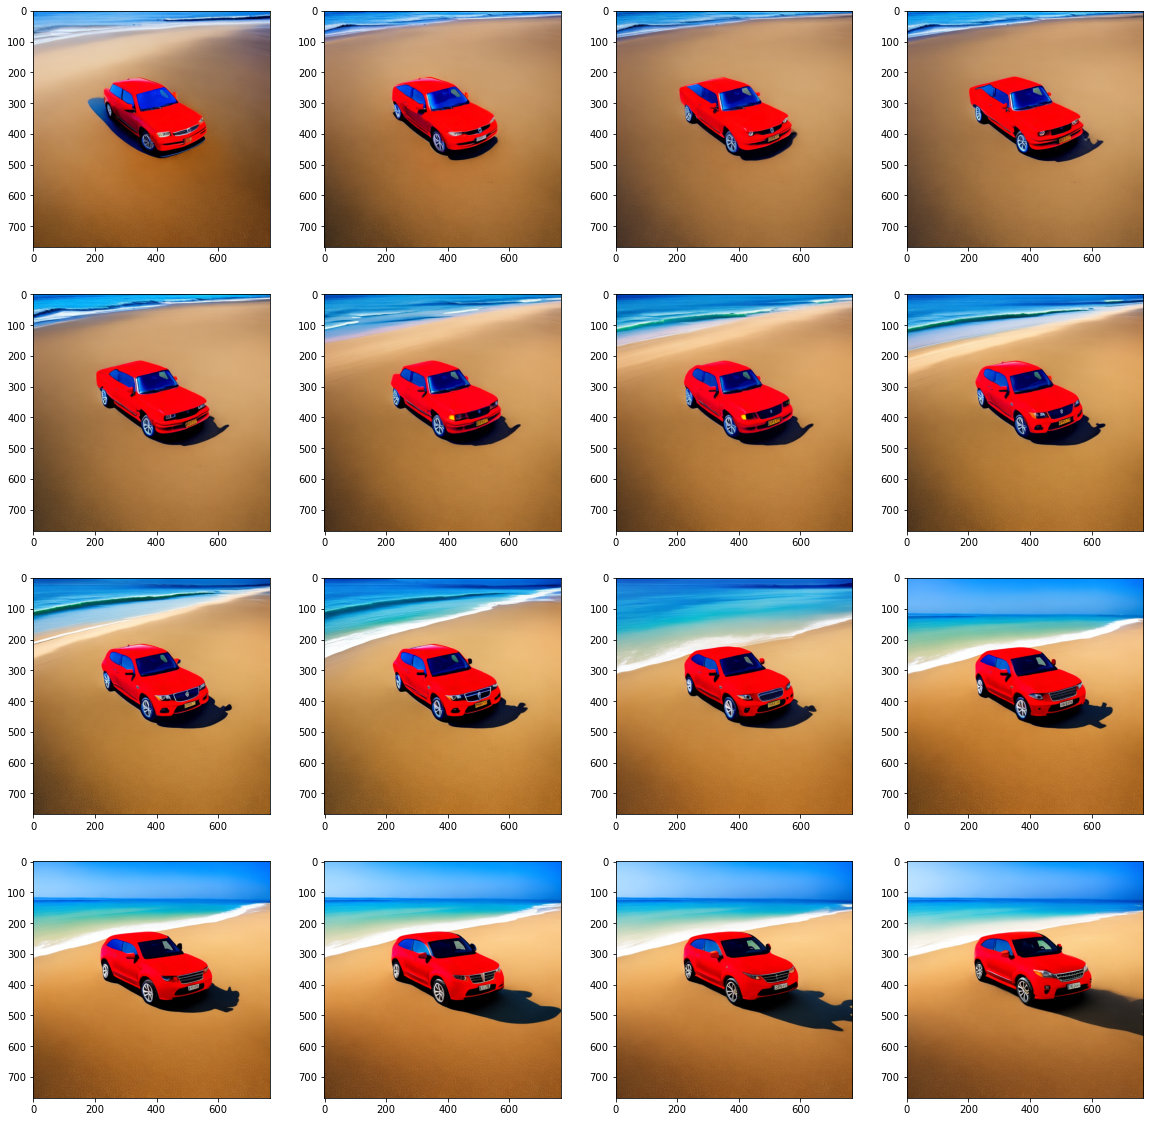

In [33]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(np.array(img_list[i]))
    # plt.show()

In [42]:
img_list = []
for idx in range(len(orientations)):
    
    p = torch.Tensor([(float(illuminations[idx]))/44.])
    p2 = torch.Tensor([float(poses[idx])/20.]) 
    # 44. and 20. are the pre-defined number to normalize the attributes between 0 to 0.5
    x = torch.Tensor(
            [torch.sin(2 * torch.pi * p), torch.cos(2 * torch.pi * p),
            torch.sin(2 * torch.pi * p2), torch.cos(2 * torch.pi * p2)]).cuda()
    continuous_word_model = continuous_word_model.cuda()
    mlp_emb = continuous_word_model(torch.unsqueeze(x, dim=0))
    
    
    """Replacing the rare token embeddings with the outputs of the MLP"""  
    with torch.no_grad():
        pipe.text_encoder.get_input_embeddings().weight[corresponding_emb] = mlp_emb[:,:1024].squeeze(0)
        pipe.text_encoder.get_input_embeddings().weight[corresponding_emb2] = mlp_emb[:,1024:].squeeze(0)
        
    torch.manual_seed(125)
    
    """Example Prompts"""
    prompt = "phtorealistic, a sks hta photo of toy hippo with tropical forest in the background"

    image = pipe(prompt, negative_prompt="bnha, lowres, bad anatomy, bad hands, cropped, worst quality, rendering", guidance_scale=6, num_inference_steps=20).images[0]


    img_list.append(image)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

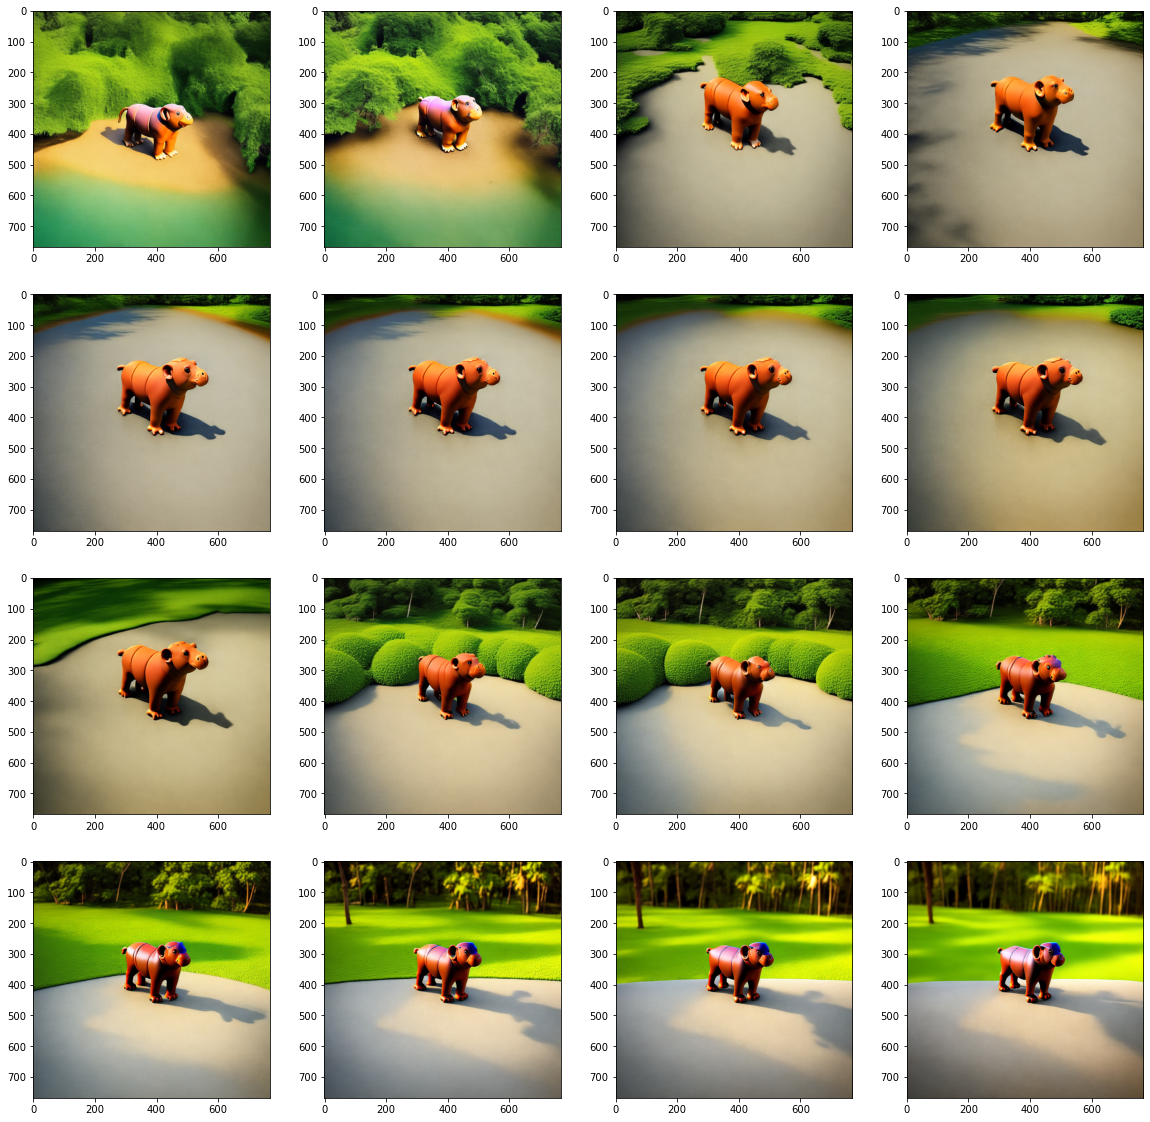

In [43]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(np.array(img_list[i]))